# Lasso coefficients comparison
---
***Objective:*** The objetive of this notebook is to apply the Lasso regression with several kinds of priors and compare it's coefficients.

***Author:*** Bruno G. de Oliveira

### 1) Importing packages

In [1]:
import sys 
sys.path.append('../')

# Data manipulation 
import pandas as pd 
import numpy as np 
pd.options.display.max_rows=None

# Dataset creation
from dataset.generate_regression_data import RegressionData

# Probabilistic programming
import pymc3 as pm 
import theano as T
from models.horseshoe import bayesian_lr_with_horseshoe_prior

# Data visualization
import matplotlib.pyplot as plt 
import seaborn as sns 

%matplotlib inline 

### 2) Create toy dataset

This dataset is built usign scikit-learn function called `make_regression`(https://scikit-learn.org/stable/modules/generated/sklearn.datasets.make_regression.html#sklearn.datasets.make_regression) which simulates data from a multivariate normal distribution and we can pass as parameters the number of samples, the number of features and the number of informative features that we want.

In [2]:
args = {
    'n_samples': 100,
    'n_features': 10,
    'nonzero_features': 4,
    'seed': 42
}

In [3]:
data = RegressionData(args)
X, y, coefs = data.generate()

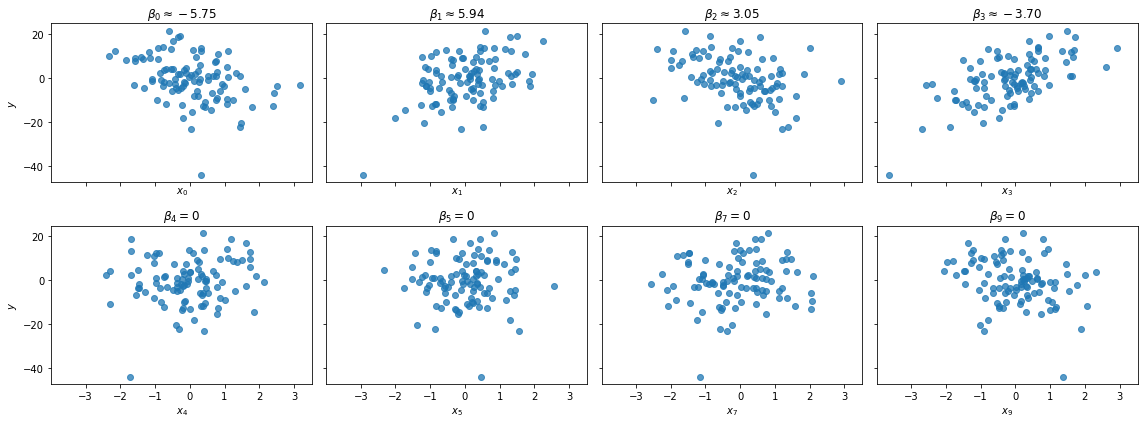

In [4]:
_ = data.plot(X, y, coefs)

### 3) Exploratory data analysis

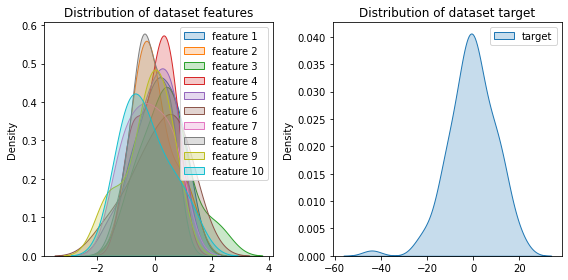

In [5]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(8,4), tight_layout=True)

for i in range(X[:, :10].shape[1]):
    sns.kdeplot(X[i], shade=True, label=f'feature {i + 1}', ax=ax[0])
ax[0].legend()
ax[0].set_title('Distribution of dataset features')

sns.kdeplot(y, shade=True, label='target', ax=ax[1])
ax[1].legend()
ax[1].set_title('Distribution of dataset target');

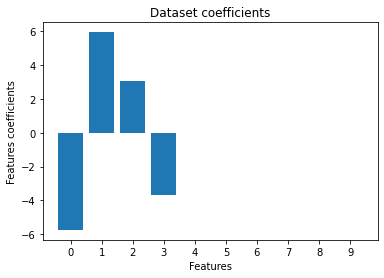

In [6]:
x = range(coefs.size)
plt.bar(x, coefs)
plt.xticks(x)
plt.xlabel('Features')
plt.ylabel('Features coefficients')
plt.title('Dataset coefficients');

### 4) Constructing the models

In [7]:
X_t = T.shared(X)

#### 4.3) Horseshoe

In [8]:
horseshoe = bayesian_lr_with_horseshoe_prior(X, y)

In [9]:
CHAINS = 3

SAMPLE_KWARGS = {
    'cores': CHAINS,
    'target_accept': 0.99,
    'max_treedepth': 15,
    'random_seed': [args['seed'] + i for i in range(CHAINS)],
    'return_inferencedata': True
}

with horseshoe:
    trace = pm.sample(**SAMPLE_KWARGS)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (3 chains in 3 jobs)
NUTS: [beta_0, z, tau, lambda, sigma]


Sampling 3 chains for 1_000 tune and 1_000 draw iterations (3_000 + 3_000 draws total) took 654 seconds.
There were 31 divergences after tuning. Increase `target_accept` or reparameterize.
There were 24 divergences after tuning. Increase `target_accept` or reparameterize.
There were 21 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.


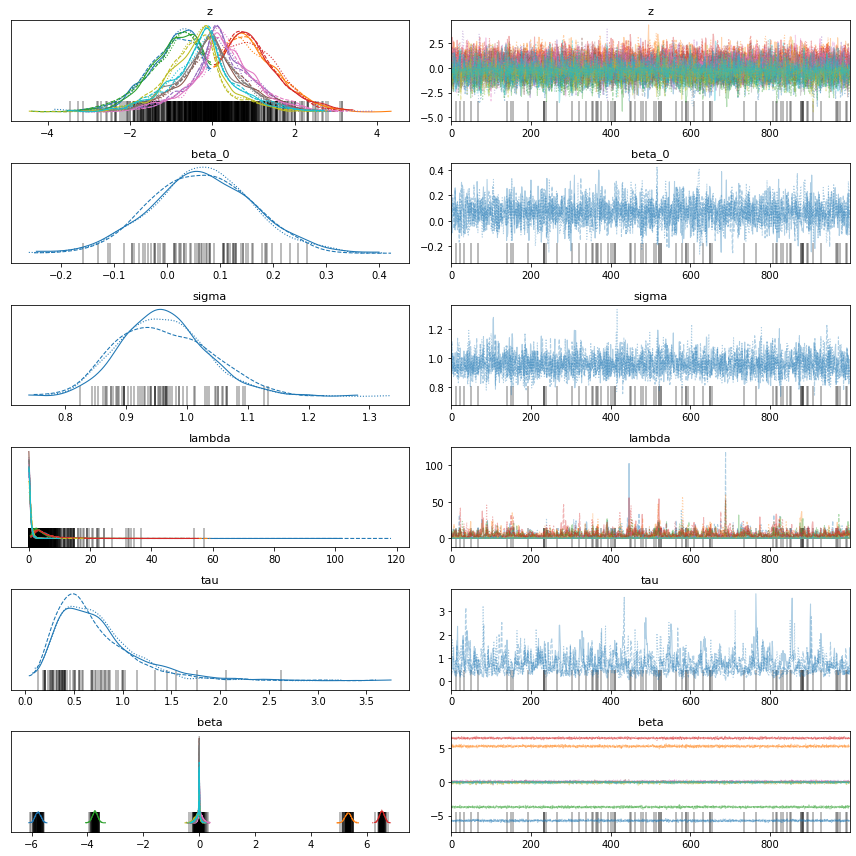

In [10]:
pm.plot_trace(trace)
plt.tight_layout();

In [11]:
trace_summary = pm.summary(trace, round_to=2)
trace_summary[['mean', 'sd', 'hdi_3%', 'hdi_97%']]

,mean,sd,hdi_3%,hdi_97%
z[0],-1.01,0.63,-2.09,-0.04
z[1],1.04,0.66,0.03,2.21
z[2],-1.00,0.64,-2.11,-0.03
z[3],1.02,0.62,0.05,2.13
z[4],0.20,0.83,-1.53,1.76
z[5],0.01,0.85,-1.68,1.67
z[6],0.26,0.82,-1.54,1.77
z[7],-0.09,0.81,-1.76,1.42
z[8],-0.40,0.78,-1.96,1.13
z[9],-0.22,0.83,-1.82,1.48


In [12]:
beta_idx = [idx for idx in trace_summary.index if idx.startswith('beta')]
beta_coefs = trace_summary.loc[beta_idx, 'mean']

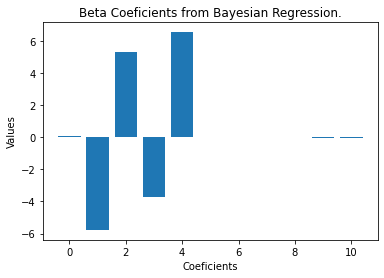

In [13]:
plt.bar(range(beta_coefs.size), beta_coefs)
plt.title('Beta Coeficients from Bayesian Regression.')
plt.xlabel('Coeficients')
plt.ylabel('Values');